### Q4. Build a model to forecast the number of trips by hour for the next 12 hours after Feb 12th 10:00 am. How well did you do?

### Import preprecessed data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [176]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Yixuan_Zhou_Assignment/clean_df')
data = data.drop(columns=['Unnamed: 0','Store_and_fwd_flag','Pickup_longitude','Pickup_latitude','Dropoff_longitude','Dropoff_latitude','Tip_amount','improvement_surcharge','Extra','pmonth'])

In [177]:
data.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,RateCodeID,Passenger_count,Trip_distance,Fare_amount,MTA_tax,Tolls_amount,Total_amount,Payment_type,Trip_type,pday,phour,weekday_or_weekend,day_name,day_period
0,2,2016-02-01 00:00:01,2016-02-01 00:10:06,1,1,2.86,10.5,0.5,0.0,11.80,2,1.0,1,0,Weekday,1-Monday,Late Night
1,2,2016-02-01 00:01:33,2016-02-01 00:20:13,1,1,3.35,13.0,0.5,0.0,14.30,2,1.0,1,0,Weekday,1-Monday,Late Night
2,2,2016-02-01 00:03:46,2016-02-01 00:21:04,1,1,4.70,17.5,0.5,0.0,22.56,1,1.0,1,0,Weekday,1-Monday,Late Night
3,2,2016-02-01 00:00:05,2016-02-01 00:06:48,1,1,2.11,8.0,0.5,0.0,9.30,2,1.0,1,0,Weekday,1-Monday,Late Night
4,2,2016-02-01 00:06:20,2016-02-01 00:08:47,1,5,0.98,5.0,0.5,0.0,6.30,2,1.0,1,0,Weekday,1-Monday,Late Night


### Create Training set and Validation Set(weekday and weekend):
- a hourly aggregated training set containing records before Feb 12th 11am 

- a hourly aggregated validation set containing records from Feb 12th 11 am to Feb 12th 22 pm

In [178]:
# Create training set
last_index = data.loc[(data['pday'] == 12) & (data['phour'] == 10)].index[-1]
feb12 = data[:last_index+1]
print(feb12)
feb12['lpep_pickup_datetime']= pd.to_datetime(feb12['lpep_pickup_datetime'])
feb12['time'] = feb12['lpep_pickup_datetime'].dt.strftime('%Y-%m-%d %H')

        VendorID lpep_pickup_datetime  ...  day_name  day_period
0              2  2016-02-01 00:00:01  ...  1-Monday  Late Night
1              2  2016-02-01 00:01:33  ...  1-Monday  Late Night
2              2  2016-02-01 00:03:46  ...  1-Monday  Late Night
3              2  2016-02-01 00:00:05  ...  1-Monday  Late Night
4              2  2016-02-01 00:06:20  ...  1-Monday  Late Night
...          ...                  ...  ...       ...         ...
557824         1  2016-02-12 10:00:27  ...  5-Friday     Morning
557825         1  2016-02-12 10:00:08  ...  5-Friday     Morning
557826         1  2016-02-12 10:00:05  ...  5-Friday     Morning
557827         1  2016-02-12 10:00:02  ...  5-Friday     Morning
557828         1  2016-02-12 10:00:03  ...  5-Friday     Morning

[557829 rows x 17 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Create hourly counts of trip before Feb 12 at 10am. And modify the dataset to have Prophet expected structure

In [5]:
feb12_hour = feb12.groupby(['time'])["day_name"].count().to_frame().reset_index()
feb12_hour.rename(columns={'day_name':'number_of_trips'},inplace=True)
feb12_hour['time'] = pd.to_datetime(feb12_hour['time'])
# ds is hourly time, y is the number of trips by hour
feb12_hour.columns = ['ds', 'y']

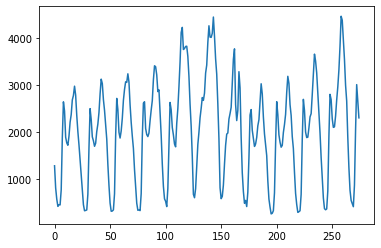

In [8]:
plt.plot(feb12_hour.y)

In [9]:
# Create test set
start_at = data.loc[(data['pday'] == 12) & (data['phour'] == 11)].index[0]
end_at = data.loc[(data['pday'] == 12) & (data['phour'] == 22)].index[-1]
print(start_at)
feb12_test = data[start_at:end_at+1]
print(feb12_test)
feb12_test['lpep_pickup_datetime']= pd.to_datetime(feb12_test['lpep_pickup_datetime'])
feb12_test['time'] = feb12_test['lpep_pickup_datetime'].dt.strftime('%Y-%m-%d %H')

557829
        VendorID lpep_pickup_datetime  ...  day_name  day_period
557829         2  2016-02-12 11:51:30  ...  5-Friday     Morning
557830         2  2016-02-12 11:39:01  ...  5-Friday     Morning
557831         2  2016-02-12 11:57:11  ...  5-Friday     Morning
557832         2  2016-02-12 11:13:39  ...  5-Friday     Morning
557833         2  2016-02-12 11:23:22  ...  5-Friday     Morning
...          ...                  ...  ...       ...         ...
598982         1  2016-02-12 22:00:29  ...  5-Friday       Night
598983         1  2016-02-12 22:00:17  ...  5-Friday       Night
598984         1  2016-02-12 22:00:20  ...  5-Friday       Night
598985         1  2016-02-12 22:00:08  ...  5-Friday       Night
598986         1  2016-02-12 22:00:04  ...  5-Friday       Night

[41158 rows x 16 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Create hourly counts of trip from Feb 12 at 11am to 22pm

In [10]:
feb12_test_hour = feb12_test.groupby(['time'])["day_name"].count().to_frame().reset_index()
feb12_test_hour.rename(columns={'day_name':'number_of_trips'},inplace=True)
feb12_test_hour['time'] = pd.to_datetime(feb12_test_hour['time'])
# ds is hourly time, y is the number of trips by hour
feb12_test_hour.columns = ['ds', 'y']
feb12_test_hour

,ds,y
0,2016-02-12 11:00:00,2170
1,2016-02-12 12:00:00,2020
2,2016-02-12 13:00:00,2100
3,2016-02-12 14:00:00,2710
4,2016-02-12 15:00:00,3007
5,2016-02-12 16:00:00,3506
6,2016-02-12 17:00:00,4032
7,2016-02-12 18:00:00,4559
8,2016-02-12 19:00:00,4720
9,2016-02-12 20:00:00,4421


Concatenated train and test set for visualization purpose

In [11]:
until22pm = feb12_hour.append(feb12_test_hour)
until22pm

,ds,y
0,2016-02-01 00:00:00,1287
1,2016-02-01 01:00:00,818
2,2016-02-01 02:00:00,581
3,2016-02-01 03:00:00,427
4,2016-02-01 04:00:00,462
...,...,...
7,2016-02-12 18:00:00,4559
8,2016-02-12 19:00:00,4720
9,2016-02-12 20:00:00,4421
10,2016-02-12 21:00:00,4046




---



---



### Create a hourly aggregated dataframe containing records before Feb 12th 11am (weekday only)

As you see here, the Feb 12 is weekday, and the next 12 hour after 10am (22pm) is still in the Feb 12. It's reasonable we only use weekday data as training data.

In [ ]:
data.loc[(data['pday'] == 12) & (data['phour'] == 10),'weekday_or_weekend']

555526    Weekday
555527    Weekday
555528    Weekday
555529    Weekday
555530    Weekday
           ...   
557824    Weekday
557825    Weekday
557826    Weekday
557827    Weekday
557828    Weekday
Name: weekday_or_weekend, Length: 2303, dtype: object

Create hourly counts of trip before Feb 12 at 10am. And modify the dataset to have Prophet expected structure

In [ ]:
feb12_weekdays = feb12[feb12.weekday_or_weekend=='Weekday']
feb12_weekdays = feb12.groupby(['time'])["day_name"].count().to_frame().reset_index()
feb12_weekdays.rename(columns={'day_name':'number_of_trips'},inplace=True)
feb12_weekdays['time'] = pd.to_datetime(feb12_weekdays['time'])
feb12_weekdays.columns = ['ds', 'y']
feb12_weekdays

,ds,y
0,2016-02-01 00:00:00,1287
1,2016-02-01 01:00:00,818
2,2016-02-01 02:00:00,581
3,2016-02-01 03:00:00,427
4,2016-02-01 04:00:00,462
...,...,...
270,2016-02-12 06:00:00,877
271,2016-02-12 07:00:00,2047
272,2016-02-12 08:00:00,3007
273,2016-02-12 09:00:00,2668


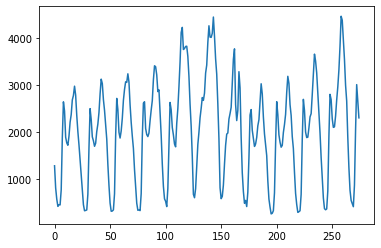

In [ ]:
plt.plot(feb12_weekdays.y)

## Time Series Forecasting with Prophet
- **Intro:** Prophet is an open-source library developed by Facebook and designed for automatic forecasting of univariate time series data
- **Advantageous:** It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well



In [ ]:
%%capture
!sudo pip install fbprophet

In [ ]:
# check prophet version
import fbprophet
import warnings
# print version number
print('Prophet %s' % fbprophet.__version__)
warnings.filterwarnings("ignore")

Prophet 0.7.1


In [ ]:
from fbprophet import Prophet
# define the model
model = Prophet()
# fit the model with training data feb12_hour
model.fit(feb12_hour)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [ ]:
future_data = pd.DataFrame(until22pm.ds)
future_data 

,ds
0,2016-02-01 00:00:00
1,2016-02-01 01:00:00
2,2016-02-01 02:00:00
3,2016-02-01 03:00:00
4,2016-02-01 04:00:00
...,...
7,2016-02-12 18:00:00
8,2016-02-12 19:00:00
9,2016-02-12 20:00:00
10,2016-02-12 21:00:00


                   ds         yhat  yhat_lower   yhat_upper
0 2016-02-01 00:00:00  1567.094708  868.874212  2262.602726
1 2016-02-01 01:00:00  1207.052759  490.131475  1968.226026
2 2016-02-01 02:00:00   777.769727   58.012234  1483.349003
3 2016-02-01 03:00:00   356.329644 -374.337410  1076.536534
4 2016-02-01 04:00:00   121.895712 -606.470217   849.494329 



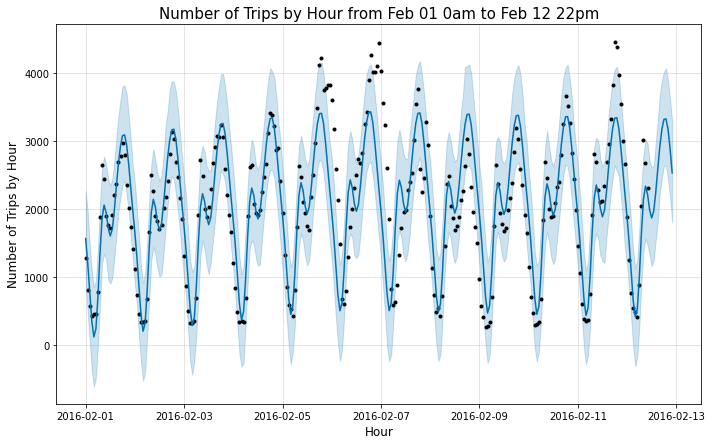

In [ ]:
# use the model to make a forecast
forecast_all = model.predict(future_data)
# summarize the forecast
print(forecast_all[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(),'\n')
# plot forecast
model.plot(forecast_all)
plt.title('Number of Trips by Hour from Feb 01 0am to Feb 12 22pm',fontsize=15)
plt.ylabel('Number of Trips by Hour',fontsize=12)
plt.xlabel('Hour',fontsize=12)
plt.show()

It reveals what looks like some cyclical patterns in the data. 

We can see that the forecasted hourly trips is a good match for the real observations, especially when the bounds are taken into account!

The lower and upper bounds on the predicted value (‘yhat_lower‘ and ‘yhat_upper‘) that provide uncertainty of the forecast.

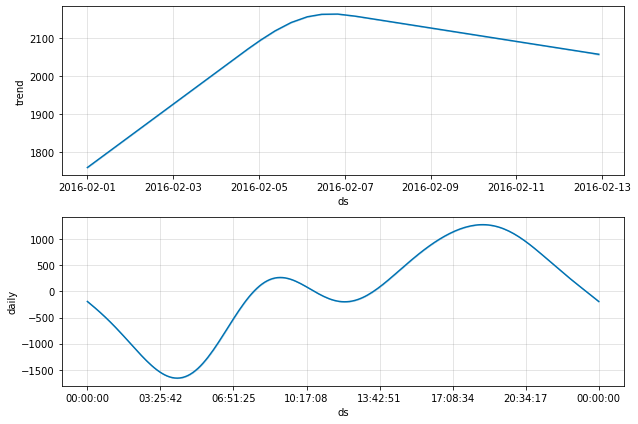

In [ ]:
model.plot_components(forecast_all);

It's noted that Prophet takes overall trend of each day and daily trend of each hour into consideration during training. 

In [ ]:
# define the period for which we want a prediction
future = list()
for i in range(11, 23):
	date = '2016-02-12 %02d'%i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
future

,ds
0,2016-02-12 11:00:00
1,2016-02-12 12:00:00
2,2016-02-12 13:00:00
3,2016-02-12 14:00:00
4,2016-02-12 15:00:00
5,2016-02-12 16:00:00
6,2016-02-12 17:00:00
7,2016-02-12 18:00:00
8,2016-02-12 19:00:00
9,2016-02-12 20:00:00


In [ ]:
# use the model to make a forecast
from sklearn.metrics import mean_absolute_error
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],'\n')


                    ds         yhat   yhat_lower   yhat_upper
0  2016-02-12 11:00:00  1989.241765  1310.296351  2709.005725
1  2016-02-12 12:00:00  1867.449711  1140.752508  2583.356450
2  2016-02-12 13:00:00  1962.858197  1208.496618  2708.033930
3  2016-02-12 14:00:00  2240.885214  1496.348560  2946.894896
4  2016-02-12 15:00:00  2591.711753  1842.739411  3277.187553
5  2016-02-12 16:00:00  2918.576160  2154.560148  3638.008489
6  2016-02-12 17:00:00  3170.081507  2476.303300  3877.689394
7  2016-02-12 18:00:00  3315.898636  2510.837463  4001.615866
8  2016-02-12 19:00:00  3322.207999  2655.848795  4034.281647
9  2016-02-12 20:00:00  3167.628344  2450.769219  3879.320179
10 2016-02-12 21:00:00  2878.546846  2131.229835  3612.880908
11 2016-02-12 22:00:00  2529.414314  1773.060339  3295.609901 



MAE: 766.958 



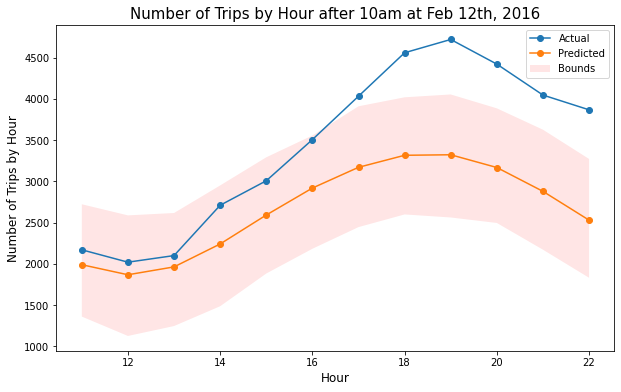

In [ ]:
# zoom in to next 12 hour:
y_true = feb12_test_hour['y'].values
y_pred = forecast['yhat'].values
plt.figure(figsize=(10,6))
plt.plot(np.arange(11,23),y_true, label='Actual',marker='o')
plt.plot(np.arange(11,23),y_pred, label='Predicted',marker='o')
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae,'\n')
# plt.xticks(np.arange(12), np.arange(11,23))
plt.title('Number of Trips by Hour after 10am at Feb 12th, 2016',fontsize=15)
plt.ylabel('Number of Trips by Hour',fontsize=12)
plt.fill_between(np.arange(11,23),forecast['yhat_lower'].values, forecast['yhat_upper'].values, facecolor='red', alpha=0.1,
                label='Bounds')
plt.xlabel('Hour',fontsize=12)
plt.legend()
plt.show()


The model predicted well in the lower/valley part of number of trips by hour (11:00 to 13:00), but not so good at the higher/peak part (14:00 to 22:00). 

Overall, the predicted model performs good with mean absolute error of 767 trips.


In addition, Prophet can also incorporate possible effects from manually specified time range.

In [ ]:
weekend_feb12 = feb12[feb12.weekday_or_weekend=='Weekend']
weekend_time = list(weekend_feb12.time.unique())
print(weekend_time)
weekends = pd.DataFrame({  
  'holiday': 'weekend',
  'ds': pd.to_datetime(weekend_time),
  'lower_window': 0,
  'upper_window': 1,
})

['2016-02-06 00', '2016-02-06 01', '2016-02-06 02', '2016-02-06 03', '2016-02-06 04', '2016-02-06 05', '2016-02-06 06', '2016-02-06 07', '2016-02-06 08', '2016-02-06 09', '2016-02-06 10', '2016-02-06 11', '2016-02-06 12', '2016-02-06 13', '2016-02-06 14', '2016-02-06 15', '2016-02-06 16', '2016-02-06 17', '2016-02-06 18', '2016-02-06 19', '2016-02-06 20', '2016-02-06 21', '2016-02-06 22', '2016-02-06 23', '2016-02-07 00', '2016-02-07 01', '2016-02-07 02', '2016-02-07 03', '2016-02-07 04', '2016-02-07 05', '2016-02-07 06', '2016-02-07 07', '2016-02-07 08', '2016-02-07 09', '2016-02-07 10', '2016-02-07 11', '2016-02-07 12', '2016-02-07 13', '2016-02-07 14', '2016-02-07 15', '2016-02-07 16', '2016-02-07 17', '2016-02-07 18', '2016-02-07 19', '2016-02-07 20', '2016-02-07 21', '2016-02-07 22', '2016-02-07 23']


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


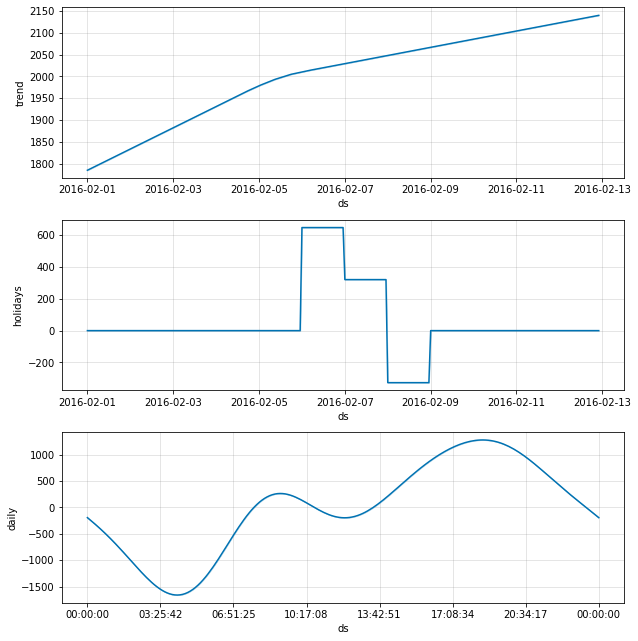

In [ ]:
m = Prophet(holidays=weekends)  
forecast_thinkweekend = m.fit(feb12_hour).predict(future_data)  
m.plot_components(forecast_thinkweekend);

Our component plot now includes a holidays component, which is the weekends we specified), with spikes indicating the magnitude of influence those holidays have on the value.

                     ds         yhat   yhat_lower   yhat_upper
0   2016-02-01 00:00:00  1591.727586   925.372545  2202.683430
1   2016-02-01 01:00:00  1229.338656   595.723540  1936.958872
2   2016-02-01 02:00:00   798.080546   112.045643  1471.988468
3   2016-02-01 03:00:00   375.211884  -267.763285  1095.587848
4   2016-02-01 04:00:00   139.660688  -504.041070   807.880647
..                  ...          ...          ...          ...
282 2016-02-12 18:00:00  3393.890774  2724.644387  4051.238269
283 2016-02-12 19:00:00  3401.691686  2763.690708  4079.147485
284 2016-02-12 20:00:00  3248.493103  2556.873642  3887.635317
285 2016-02-12 21:00:00  2960.703653  2238.713238  3588.483610
286 2016-02-12 22:00:00  2612.715167  1888.949125  3212.498771

[287 rows x 4 columns] 



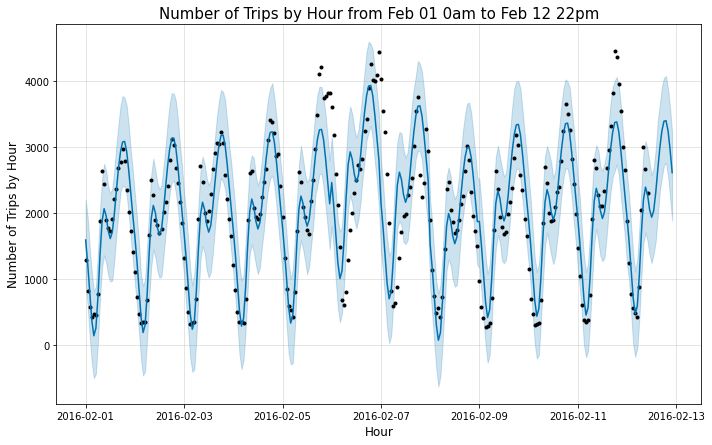

In [ ]:
# summarize the forecast
print(forecast_thinkweekend[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],'\n')
# plot forecast
m.plot(forecast_thinkweekend)
plt.title('Number of Trips by Hour from Feb 01 0am to Feb 12 22pm',fontsize=15)
plt.ylabel('Number of Trips by Hour',fontsize=12)
plt.xlabel('Hour',fontsize=12)
plt.show()

                    ds         yhat   yhat_lower   yhat_upper
0  2016-02-12 11:00:00  2055.761733  1373.747901  2751.991941
1  2016-02-12 12:00:00  1936.821652  1275.281353  2619.361108
2  2016-02-12 13:00:00  2034.227021  1338.180577  2684.612394
3  2016-02-12 14:00:00  2313.536962  1651.016105  3017.487361
4  2016-02-12 15:00:00  2665.417723  1950.114110  3324.258385
5  2016-02-12 16:00:00  2993.513049  2313.559208  3693.900416
6  2016-02-12 17:00:00  3246.503009  2523.773459  3917.988586
7  2016-02-12 18:00:00  3393.890774  2711.749980  4070.151618
8  2016-02-12 19:00:00  3401.691686  2731.843882  4102.228202
9  2016-02-12 20:00:00  3248.493103  2571.301124  3952.148013
10 2016-02-12 21:00:00  2960.703653  2261.919422  3644.499485
11 2016-02-12 22:00:00  2612.715167  1976.072235  3324.795541 

MAE: 691.227 



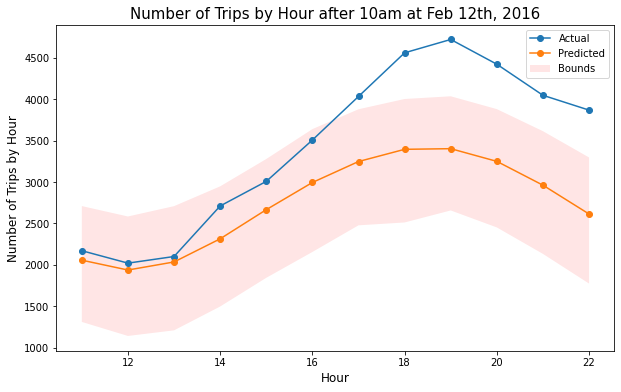

In [ ]:
forecast_thinkweekend_predict = m.predict(future)
# summarize the forecast
print(forecast_thinkweekend_predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],'\n')

# zoom in to next 12 hour:
y_true_thinkweekend = feb12_test_hour['y'].values
y_pred_thinkweekend = forecast_thinkweekend_predict['yhat'].values
plt.figure(figsize=(10,6))
plt.plot(np.arange(11,23),y_true_thinkweekend, label='Actual',marker='o')
plt.plot(np.arange(11,23),y_pred_thinkweekend, label='Predicted',marker='o')
mae = mean_absolute_error(y_true_thinkweekend, y_pred_thinkweekend)
print('MAE: %.3f' % mae,'\n')
# plt.xticks(np.arange(12), np.arange(11,23))
plt.fill_between(np.arange(11,23),forecast['yhat_lower'].values, forecast['yhat_upper'].values, facecolor='red', alpha=0.1,
                label='Bounds')
plt.title('Number of Trips by Hour after 10am at Feb 12th, 2016',fontsize=15)
plt.ylabel('Number of Trips by Hour',fontsize=12)
plt.xlabel('Hour',fontsize=12)
plt.legend()
plt.show()

After taking the weekend effects into consideration, we see that the mean absolute error decreased from 767 to 691!! Great!



---



---



## Predict by Vendor category, and take the difference between weekend and weekday into consideration

Next, let's split data based vendorID
- A code indication LPEP provider that provided the record

- 1=Creative Mobile Technologies,LLC
- 2=VeriFone Inc

In [ ]:
data.VendorID.unique()

array([2, 1])

In [ ]:
Vendor1 = data[data.VendorID==1].reset_index(drop=True)
Vendor2 = data[data.VendorID==2].reset_index(drop=True)

In [ ]:
def create_hr_train(df):
  # Create Vendor1 training set
  last_idx = df.loc[(df['pday'] == 12) & (df['phour'] == 10)].index[-1]
  feb12_df = df[:last_idx+1]
  feb12_df['lpep_pickup_datetime']= pd.to_datetime(feb12_df['lpep_pickup_datetime'])
  feb12_df['time'] = feb12_df['lpep_pickup_datetime'].dt.strftime('%Y-%m-%d %H')
  # hourly aggregate Vendor1
  feb12_hour_df = feb12_df.groupby(['time'])["day_name"].count().to_frame().reset_index()
  feb12_hour_df.rename(columns={'day_name':'number_of_trips'},inplace=True)
  feb12_hour_df['time'] = pd.to_datetime(feb12_hour_df['time'])
  # ds is hourly time, y is the number of trips by hour
  feb12_hour_df.columns = ['ds', 'y']
  return feb12_hour_df


def create_hr_test(df):
  start_at = df.loc[(df['pday'] == 12) & (df['phour'] == 11)].index[0]
  end_at = df.loc[(df['pday'] == 12) & (df['phour'] == 22)].index[-1]
  v1_feb12_test = df[start_at:end_at+1]
  v1_feb12_test['lpep_pickup_datetime']= pd.to_datetime(v1_feb12_test['lpep_pickup_datetime'])
  v1_feb12_test['time'] = v1_feb12_test['lpep_pickup_datetime'].dt.strftime('%Y-%m-%d %H')
  v1_feb12_test_hour = v1_feb12_test.groupby(['time'])["day_name"].count().to_frame().reset_index()
  v1_feb12_test_hour.rename(columns={'day_name':'number_of_trips'},inplace=True)
  v1_feb12_test_hour['time'] = pd.to_datetime(v1_feb12_test_hour['time'])
  # ds is hourly time, y is the number of trips by hour
  v1_feb12_test_hour.columns = ['ds', 'y']
  return v1_feb12_test_hour

In [ ]:
# Create Vendor1 training set
v1_train = create_hr_train(Vendor1)
# Create Vendor2 training set
v2_train = create_hr_train(Vendor2)

# Create Vendor1 test set
v1_test = create_hr_test(Vendor1)
# Create Vendor1 test set
v2_test = create_hr_test(Vendor2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


                     ds        yhat  yhat_lower  yhat_upper
0   2016-02-01 00:00:00  317.212813  182.908348  459.902374
1   2016-02-01 01:00:00  244.562285   97.512581  384.220361
2   2016-02-01 02:00:00  155.674281   21.464708  303.191878
3   2016-02-01 03:00:00   70.230182  -63.411256  206.828870
4   2016-02-01 04:00:00   30.013855 -126.983188  172.305547
..                  ...         ...         ...         ...
282 2016-02-12 18:00:00  716.483241  575.707168  845.823539
283 2016-02-12 19:00:00  706.074990  557.628637  846.181592
284 2016-02-12 20:00:00  661.959212  517.485831  799.381725
285 2016-02-12 21:00:00  593.102749  448.461571  732.162935
286 2016-02-12 22:00:00  517.625941  385.435564  656.461252

[287 rows x 4 columns] 



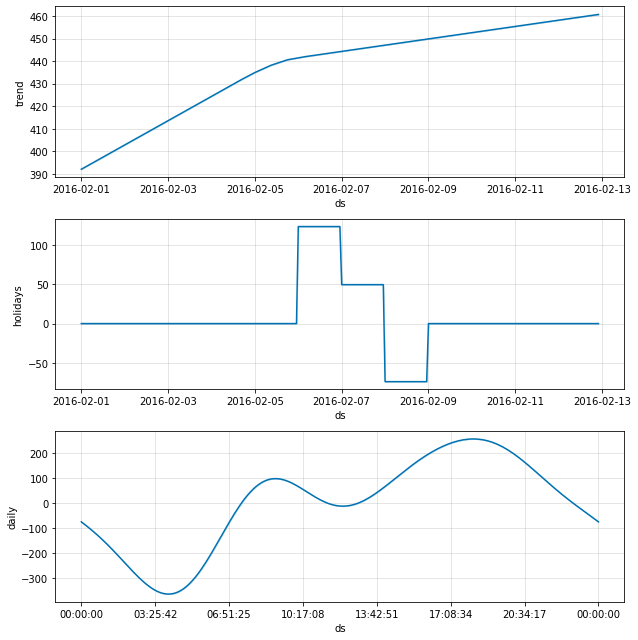

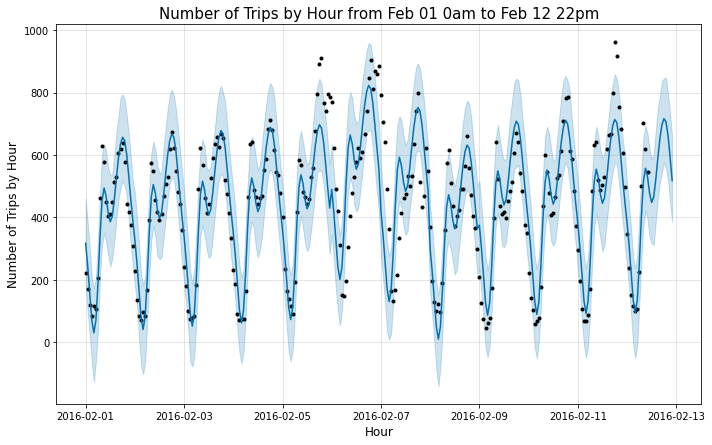

In [ ]:
v1m = Prophet(holidays=weekends)  
# predict 02-01 00 to 02-12 22 (future_data) values; 
v1forecast_thinkweekend = v1m.fit(v1_train).predict(future_data)  
v1m.plot_components(v1forecast_thinkweekend);
# summarize the forecast
print(v1forecast_thinkweekend[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],'\n')
# plot forecast
v1m.plot(v1forecast_thinkweekend)
plt.title('Number of Trips by Hour from Feb 01 0am to Feb 12 22pm',fontsize=15)
plt.ylabel('Number of Trips by Hour',fontsize=12)
plt.xlabel('Hour',fontsize=12)
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


                     ds         yhat   yhat_lower   yhat_upper
0   2016-02-01 00:00:00  1284.085514   784.315314  1853.765012
1   2016-02-01 01:00:00   993.957721   483.467328  1493.410815
2   2016-02-01 02:00:00   651.218147    65.580219  1209.051065
3   2016-02-01 03:00:00   313.532120  -198.484384   867.768537
4   2016-02-01 04:00:00   118.048317  -436.813308   674.189533
..                  ...          ...          ...          ...
282 2016-02-12 18:00:00  2689.413181  2114.572488  3212.659636
283 2016-02-12 19:00:00  2707.633525  2150.439929  3209.719878
284 2016-02-12 20:00:00  2598.370544  2056.752183  3120.803054
285 2016-02-12 21:00:00  2379.199303  1854.165414  2918.479920
286 2016-02-12 22:00:00  2106.519377  1567.257541  2655.573558

[287 rows x 4 columns] 



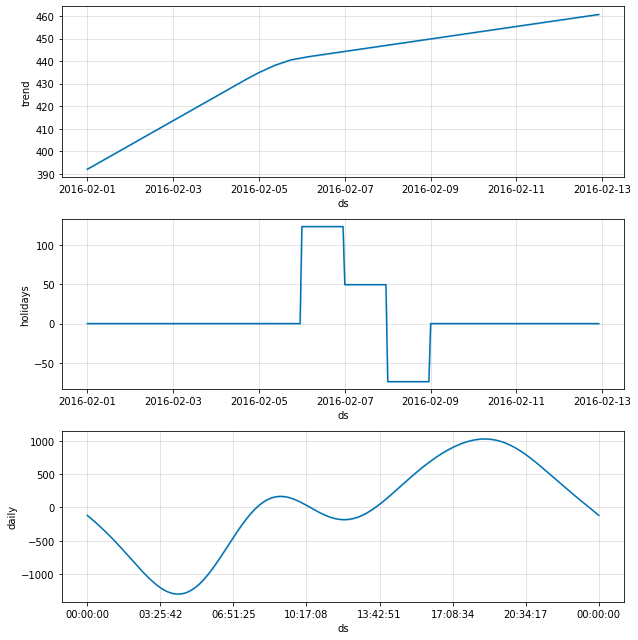

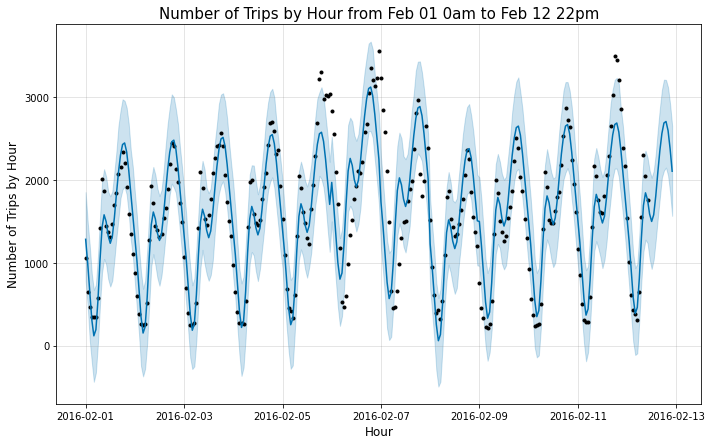

In [ ]:
v2m = Prophet(holidays=weekends)  
# predict 02-01 00 to 02-12 22 (future_data) values; 
v2forecast_thinkweekend = v2m.fit(v2_train).predict(future_data)  
v2m.plot_components(v1forecast_thinkweekend);
# summarize the forecast
print(v2forecast_thinkweekend[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],'\n')
# plot forecast
v2m.plot(v2forecast_thinkweekend)
plt.title('Number of Trips by Hour from Feb 01 0am to Feb 12 22pm',fontsize=15)
plt.ylabel('Number of Trips by Hour',fontsize=12)
plt.xlabel('Hour',fontsize=12)
plt.show()

In [ ]:
def plot_predict12hr(model,testset,name):
  # use the model to make a forecast
  forecast = model.predict(future)
  # summarize the forecast
  print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],'\n')
  # zoom in to next 12 hour:
  y_true = testset['y'].values
  y_pred = forecast['yhat'].values
  plt.figure(figsize=(10,6))
  plt.plot(np.arange(11,23),y_true, label='Actual',marker='o')
  plt.plot(np.arange(11,23),y_pred, label='Predicted',marker='o')
  mae = mean_absolute_error(y_true, y_pred)
  print('MAE: %.3f' % mae,'\n')
  # plt.xticks(np.arange(12), np.arange(11,23))
  plt.fill_between(np.arange(11,23),forecast['yhat_lower'].values, forecast['yhat_upper'].values, facecolor='red', alpha=0.1,
                label='Bounds')
  plt.title('{}: Number of Trips by Hour after 10am at Feb 12th, 2016'.format(name),fontsize=15)
  plt.xlabel('Number of Trips by Hour',fontsize=12)
  plt.ylabel('Hour',fontsize=12)
  plt.legend()
  plt.show()

                    ds        yhat  yhat_lower  yhat_upper
0  2016-02-12 11:00:00  476.784410  329.554636  621.872836
1  2016-02-12 12:00:00  448.010384  311.132718  599.315101
2  2016-02-12 13:00:00  465.246315  329.830778  604.299098
3  2016-02-12 14:00:00  519.900040  378.972824  665.564740
4  2016-02-12 15:00:00  588.412403  447.564038  731.779237
5  2016-02-12 16:00:00  650.644307  513.654433  792.706316
6  2016-02-12 17:00:00  695.665678  549.117801  837.655898
7  2016-02-12 18:00:00  716.483241  563.549126  863.731303
8  2016-02-12 19:00:00  706.074990  568.495750  842.182835
9  2016-02-12 20:00:00  661.959212  520.752408  797.432599
10 2016-02-12 21:00:00  593.102749  452.283968  728.340050
11 2016-02-12 22:00:00  517.625941  374.467759  655.512116 

MAE: 154.008 



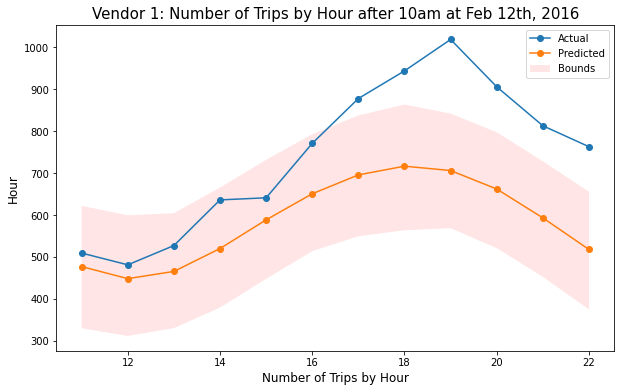

In [ ]:
plot_predict12hr(model=v1m,testset=v1_test,name='Vendor 1')

For vendor 1, we see that the mean absolute error decreased from 691 to 154!! 


                    ds         yhat   yhat_lower   yhat_upper
0  2016-02-12 11:00:00  1589.316046  1046.052586  2119.237251
1  2016-02-12 12:00:00  1499.850628   942.314381  2031.472520
2  2016-02-12 13:00:00  1580.377454  1062.623075  2120.156936
3  2016-02-12 14:00:00  1805.093305  1277.603722  2289.238033
4  2016-02-12 15:00:00  2088.452249  1611.838104  2630.933836
5  2016-02-12 16:00:00  2354.431518  1809.609523  2871.449976
6  2016-02-12 17:00:00  2562.640831  2004.285087  3075.452226
7  2016-02-12 18:00:00  2689.413181  2160.444704  3218.549849
8  2016-02-12 19:00:00  2707.633525  2190.672097  3255.511051
9  2016-02-12 20:00:00  2598.370544  2066.967684  3111.854906
10 2016-02-12 21:00:00  2379.199303  1843.167840  2897.287938
11 2016-02-12 22:00:00  2106.519377  1574.053428  2591.078245 

MAE: 526.955 



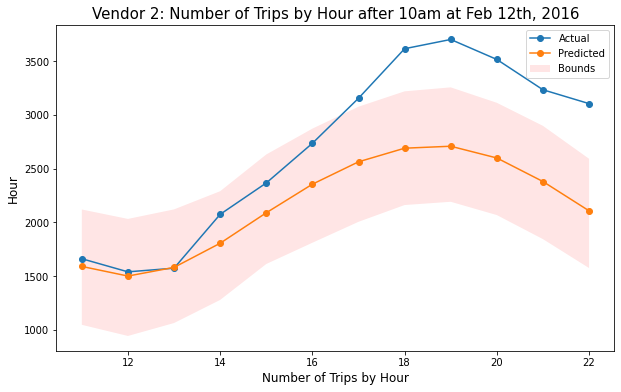

In [ ]:
plot_predict12hr(model=v2m,testset=v2_test,name='Vendor 2')

For vendor 2, we see that the mean absolute error decreased from 691 to 527!! 

## Approach 2 : LSTM

## Univariate Time Series Forecasting with LSTM

In [12]:
until22pm

,ds,y
0,2016-02-01 00:00:00,1287
1,2016-02-01 01:00:00,818
2,2016-02-01 02:00:00,581
3,2016-02-01 03:00:00,427
4,2016-02-01 04:00:00,462
...,...,...
7,2016-02-12 18:00:00,4559
8,2016-02-12 19:00:00,4720
9,2016-02-12 20:00:00,4421
10,2016-02-12 21:00:00,4046


In [318]:
import pandas as pd
import tensorflow as tf
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import random
import time

In [319]:
until22pm

,ds,y
0,2016-02-01 00:00:00,1287
1,2016-02-01 01:00:00,818
2,2016-02-01 02:00:00,581
3,2016-02-01 03:00:00,427
4,2016-02-01 04:00:00,462
...,...,...
7,2016-02-12 18:00:00,4559
8,2016-02-12 19:00:00,4720
9,2016-02-12 20:00:00,4421
10,2016-02-12 21:00:00,4046


In [320]:
# Get index of 2016-02-12 10am and stored in the train_value
train_value = until22pm[until22pm.ds =='2016-02-12 10:00:00'].index[0]
print(train_value)
# # This hour's forecast value depends on last 2-hour values 
window_size=2
# Only using "Open" feature for training 
train_data=until22pm.iloc[:(train_value+window_size+1), 1].values
# print(train_data)
train_data = train_data.reshape(-1,1)
print(train_data.shape)


274
(277, 1)


In [321]:
# preprocess training data using Minmax sclaer
# default configuration and scale values to the range 0 and 1
scaler=MinMaxScaler(feature_range=(0, 1))
train_data_transform=scaler.fit_transform(np.array(train_data))
print(train_data_transform.shape)


(277, 1)


In [322]:
# Append window-sized data to training dataset
x_train, y_train = [], []
train_len = len(train_data_transform)
for i in range(train_len-window_size):
    x_train.append(train_data_transform[i:i+window_size])
    y_train.append(train_data_transform[i+window_size])
    
x_train=np.array(x_train)
y_train=np.array(y_train)    
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

x_train shape:  (275, 2, 1)
y_train shape:  (275, 1)


In [323]:
model=Sequential(
    [LSTM(100,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])),
     Dropout(0.2),
     LSTM(50,return_sequences=True),
     Dropout(0.2),
     LSTM(50),
     Dropout(0.2),
     Dense(1),
     Activation('linear')]
    )


model.summary()
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

start = time.time()

print ('compilation time : ', time.time() - start)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 2, 100)            40800     
_________________________________________________________________
dropout_36 (Dropout)         (None, 2, 100)            0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 2, 50)             30200     
_________________________________________________________________
dropout_37 (Dropout)         (None, 2, 50)             0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_38 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)               

In [324]:
model.fit(x_train, y_train, epochs=40, batch_size=50)

Epoch 1/40
6/6 [==============================] - 5s 8ms/step - loss: 0.2354 - accuracy: 0.0016 
Epoch 2/40
6/6 [==============================] - 0s 7ms/step - loss: 0.1800 - accuracy: 0.0076
Epoch 3/40
6/6 [==============================] - 0s 8ms/step - loss: 0.1447 - accuracy: 0.0047
Epoch 4/40
6/6 [==============================] - 0s 8ms/step - loss: 0.0812 - accuracy: 0.0047
Epoch 5/40
6/6 [==============================] - 0s 9ms/step - loss: 0.0366 - accuracy: 0.0043
Epoch 6/40
6/6 [==============================] - 0s 8ms/step - loss: 0.0533 - accuracy: 0.0080
Epoch 7/40
6/6 [==============================] - 0s 7ms/step - loss: 0.0365 - accuracy: 0.0023
Epoch 8/40
6/6 [==============================] - 0s 9ms/step - loss: 0.0397 - accuracy: 0.0070
Epoch 9/40
6/6 [==============================] - 0s 7ms/step - loss: 0.0330 - accuracy: 0.0070
Epoch 10/40
6/6 [==============================] - 0s 7ms/step - loss: 0.0304 - accuracy: 0.0032
Epoch 11/40
6/6 [=====================

In [326]:
train_df = until22pm.iloc[:train_value+1]
test_df = until22pm.iloc[train_value+1:]  
print(test_df)     
# axis{0/’index’, 1/’columns’}, default 0 (vertically concatenate). 
# The axis to concatenate along.
data = pd.concat((train_df['y'], test_df['y']), axis=0)
# Include first window_size (2)data in order to predict first value of test data
test_input = data[len(train_df) - window_size:].values
print(test_input)
test_input = test_input.reshape(-1,1)
print(test_input.shape[1]==train_data.shape[1])
test_input = scaler.transform(test_input)
print(test_input.shape)       

x_test = []
        
for i in range(window_size, len(test_df)+window_size): 
  # print(i)
  x_test.append(test_input[i-window_size:i, 0])
            
x_test = np.array(x_test)
print("Input test data size: ",x_test.shape)
print(x_test)

                    ds     y
0  2016-02-12 11:00:00  2170
1  2016-02-12 12:00:00  2020
2  2016-02-12 13:00:00  2100
3  2016-02-12 14:00:00  2710
4  2016-02-12 15:00:00  3007
5  2016-02-12 16:00:00  3506
6  2016-02-12 17:00:00  4032
7  2016-02-12 18:00:00  4559
8  2016-02-12 19:00:00  4720
9  2016-02-12 20:00:00  4421
10 2016-02-12 21:00:00  4046
11 2016-02-12 22:00:00  3867
[2668 2303 2170 2020 2100 2710 3007 3506 4032 4559 4720 4421 4046 3867]
True
(14, 1)
Input test data size:  (12, 2)
[[0.57316782 0.48603485]
 [0.48603485 0.45428503]
 [0.45428503 0.41847696]
 [0.41847696 0.4375746 ]
 [0.4375746  0.58319408]
 [0.58319408 0.65409406]
 [0.65409406 0.77321556]
 [0.77321556 0.89878253]
 [0.89878253 1.02458821]
 [1.02458821 1.0630222 ]
 [1.0630222  0.99164478]
 [0.99164478 0.90212461]]


In [250]:
#Transform x_test values compatible with LSTM
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print(x_test.shape)
# print(x_test)

(12, 2, 1)


In [251]:
prediction = model.predict(x_test)
print("The shape of predicted values of test data before inverse_transform: ",\
      prediction.shape)

# Undo the scaling of prediction according to feature_range.
prediction_inverse = scaler.inverse_transform(prediction)

print("The shape of predicted values of test data after inverse_trasform: ",\
      prediction_inverse.shape)
print(prediction_inverse)

The shape of predicted values of test data before inverse_transform:  (12, 1)
The shape of predicted values of test data after inverse_trasform:  (12, 1)
[[2417.3154]
 [2181.734 ]
 [2071.4807]
 [2013.9979]
 [2219.557 ]
 [2646.    ]
 [2976.1086]
 [3462.285 ]
 [3998.4644]
 [4423.594 ]
 [4420.896 ]
 [4072.467 ]]


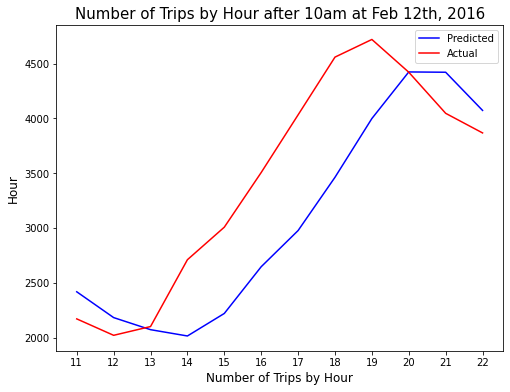

In [252]:
y_test = until22pm.iloc[train_value+1:,1].values


plt.figure(figsize=(8,6))
plt.plot(prediction_inverse, color='blue', label='Predicted')
plt.plot(y_test, color ='red', label='Actual')
plt.title('Number of Trips by Hour after 10am at Feb 12th, 2016',fontsize=15)
plt.xlabel('Number of Trips by Hour',fontsize=12)
plt.ylabel('Hour',fontsize=12)
plt.xticks(np.arange(12), np.arange(11,23))
plt.legend()
plt.show()

In [248]:
y_test = y_test.reshape(-1,1)
print('Mean Absolute Error: ', mean_absolute_error(y_test, prediction_inverse))
print('Mean Squared Error: ', mean_squared_error(y_test, prediction_inverse))

Mean Absolute Error:  519.842763264974
Mean Squared Error:  412774.69516128924


## Multivariate Time Series Forecasting with LSTM

In [187]:
end_at = data.loc[(data['pday'] == 12) & (data['phour'] == 22)].index[-1]
mul_lstm = data[:end_at]
mul_lstm['lpep_pickup_datetime']= pd.to_datetime(mul_lstm['lpep_pickup_datetime'])
mul_lstm['time'] = mul_lstm['lpep_pickup_datetime'].dt.strftime('%Y-%m-%d %H')
mul_lstm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,RateCodeID,Passenger_count,Trip_distance,Fare_amount,MTA_tax,Tolls_amount,Total_amount,Payment_type,Trip_type,pday,phour,weekday_or_weekend,day_name,day_period,time
0,2,2016-02-01 00:00:01,2016-02-01 00:10:06,1,1,2.86,10.5,0.5,0.0,11.80,2,1.0,1,0,Weekday,1-Monday,Late Night,2016-02-01 00
1,2,2016-02-01 00:01:33,2016-02-01 00:20:13,1,1,3.35,13.0,0.5,0.0,14.30,2,1.0,1,0,Weekday,1-Monday,Late Night,2016-02-01 00
2,2,2016-02-01 00:03:46,2016-02-01 00:21:04,1,1,4.70,17.5,0.5,0.0,22.56,1,1.0,1,0,Weekday,1-Monday,Late Night,2016-02-01 00
3,2,2016-02-01 00:00:05,2016-02-01 00:06:48,1,1,2.11,8.0,0.5,0.0,9.30,2,1.0,1,0,Weekday,1-Monday,Late Night,2016-02-01 00
4,2,2016-02-01 00:06:20,2016-02-01 00:08:47,1,5,0.98,5.0,0.5,0.0,6.30,2,1.0,1,0,Weekday,1-Monday,Late Night,2016-02-01 00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598981,1,2016-02-12 22:00:32,2016-02-12 22:03:09,1,2,0.70,4.0,0.5,0.0,5.30,2,1.0,12,22,Weekday,5-Friday,Night,2016-02-12 22
598982,1,2016-02-12 22:00:29,2016-02-12 22:14:30,1,1,3.30,13.5,0.5,0.0,14.80,2,1.0,12,22,Weekday,5-Friday,Night,2016-02-12 22
598983,1,2016-02-12 22:00:17,2016-02-12 22:03:24,1,3,0.50,4.0,0.5,0.0,5.30,2,1.0,12,22,Weekday,5-Friday,Night,2016-02-12 22
598984,1,2016-02-12 22:00:20,2016-02-12 22:08:12,1,2,1.50,7.5,0.5,0.0,11.00,1,1.0,12,22,Weekday,5-Friday,Night,2016-02-12 22


In [ ]:
# Check NaN by columns in the dataframe
mul_lstm.isnull().sum()

In [202]:
mul=mul_lstm.groupby("time").agg(
    number_of_trips=pd.NamedAgg(column="day_name", aggfunc='count'),
    distance_median=pd.NamedAgg(column="Trip_distance", aggfunc=np.median),
    fare_median=pd.NamedAgg(column="Fare_amount", aggfunc=np.median),
    tolls_median=pd.NamedAgg(column="Tolls_amount", aggfunc=np.median),
    totalamount_median=pd.NamedAgg(column="Total_amount", aggfunc=np.median))

In [203]:
#value 1 if the date is a weekend day and 0 if it is not
mul['WEEKDAY'] = ((pd.DatetimeIndex(mul.index).dayofweek) // 5 == 1).astype(float)

In [206]:
mul

,number_of_trips,distance_median,fare_median,tolls_median,totalamount_median,WEEKDAY
time,,,,,,
2016-02-01 00,1287,1.800,8.5,0.0,10.300,0.0
2016-02-01 01,818,1.805,8.5,0.0,10.325,0.0
2016-02-01 02,581,1.800,8.5,0.0,10.300,0.0
2016-02-01 03,427,1.980,9.0,0.0,10.380,0.0
2016-02-01 04,462,2.305,10.0,0.0,11.780,0.0
...,...,...,...,...,...,...
2016-02-12 18,4559,1.600,9.0,0.0,11.440,0.0
2016-02-12 19,4720,1.600,8.5,0.0,11.300,0.0
2016-02-12 20,4421,1.590,8.5,0.0,10.560,0.0


[[1.2870e+03 1.8000e+00 8.5000e+00 0.0000e+00 1.0300e+01 0.0000e+00]
 [8.1800e+02 1.8050e+00 8.5000e+00 0.0000e+00 1.0325e+01 0.0000e+00]
 [5.8100e+02 1.8000e+00 8.5000e+00 0.0000e+00 1.0300e+01 0.0000e+00]
 ...
 [4.4210e+03 1.5900e+00 8.5000e+00 0.0000e+00 1.0560e+01 0.0000e+00]
 [4.0460e+03 1.6200e+00 8.5000e+00 0.0000e+00 1.0380e+01 0.0000e+00]
 [3.8660e+03 1.8200e+00 8.5000e+00 0.0000e+00 1.0800e+01 0.0000e+00]]


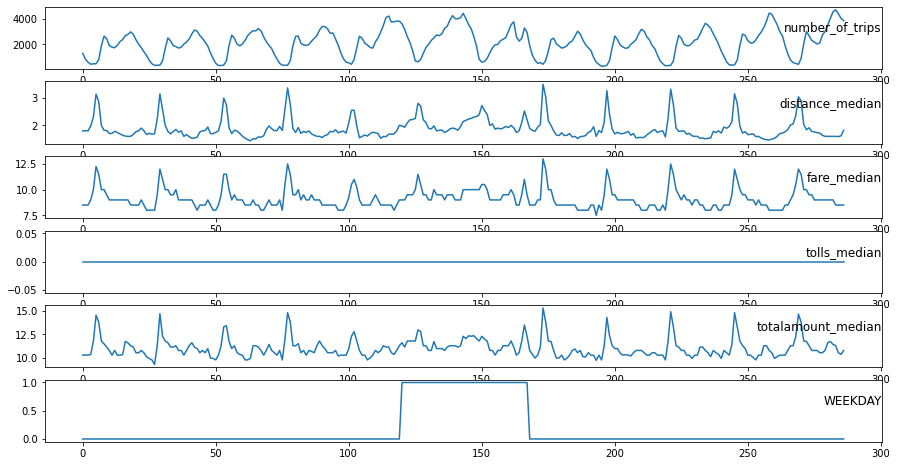

In [260]:
# creates a plot with 6 subplots showing data for each variable
dataset = mul
values = dataset.values
print(values)
# specify columns to plot
groups = [0,1,2,3,4,5]
i = 1
# plot each column
plt.figure(figsize=(15,8))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [286]:
# Get index of 2016-02-12 10am and stored in the train_value
train_value = until22pm[until22pm.ds =='2016-02-12 10:00:00'].index[0]
# This hour's forcast value depends on last 2-hour values
window_size=2
# Only using "Open" feature for training 
train_data2=mul.iloc[:(train_value+window_size+1),:].values
train_values = train_data2.astype('float32')
print(train_values.shape)
# train_data2 = train_data2.reshape(-1,1)
# print(train_data2.shape)

# training_set = mul[:11]
# print(training_set)
# values = training_set.values
# # ensure all data is float

# normalize features
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaled = scaler2.fit_transform(train_values)
print(scaled)
print(scaled.shape)

(277, 6)
[[0.24349488 0.17560971 0.18181825 0.         0.16387975 0.        ]
 [0.13153498 0.17804873 0.18181825 0.         0.1680603  0.        ]
 [0.07495822 0.17560971 0.18181825 0.         0.16387975 0.        ]
 ...
 [0.48603487 0.16585362 0.36363637 0.         0.24749172 0.        ]
 [0.45428503 0.15609753 0.27272737 0.         0.24749172 0.        ]
 [0.41847694 0.14390242 0.27272737 0.         0.24749172 0.        ]]
(277, 6)


In [279]:
# Append window-sized data to training dataset
mulx_train, muly_train = [], []
train_len = len(scaled)
for i in range(train_len-window_size):
    mulx_train.append(scaled[i:i+window_size])
    muly_train.append(scaled[i+window_size][0])

# reshape input to be 3D [samples, timesteps, features]    
mulx_train=np.array(mulx_train)
muly_train=np.array(muly_train)    
print("x_train shape: ", mulx_train.shape)
print("y_train shape: ", muly_train.shape)

x_train shape:  (275, 2, 6)
y_train shape:  (275,)


In [280]:
model2=Sequential(
    [LSTM(100,return_sequences=True,input_shape=(mulx_train.shape[1], mulx_train.shape[2])),
     Dropout(0.2),
     LSTM(50,return_sequences=True),
     Dropout(0.2),
     LSTM(50),
     Dropout(0.2),
     Dense(1),
     Activation('linear')]
    )


model2.summary()
model2.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

start = time.time()

print ('compilation time : ', time.time() - start)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 2, 100)            42800     
_________________________________________________________________
dropout_33 (Dropout)         (None, 2, 100)            0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 2, 50)             30200     
_________________________________________________________________
dropout_34 (Dropout)         (None, 2, 50)             0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_35 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)               

In [281]:
model2.fit(mulx_train, muly_train, epochs=40, batch_size=50)

Epoch 1/40
6/6 [==============================] - 4s 8ms/step - loss: 0.2300 - accuracy: 0.0047 
Epoch 2/40
6/6 [==============================] - 0s 7ms/step - loss: 0.1992 - accuracy: 0.0023
Epoch 3/40
6/6 [==============================] - 0s 7ms/step - loss: 0.1581 - accuracy: 0.0010
Epoch 4/40
6/6 [==============================] - 0s 8ms/step - loss: 0.0907 - accuracy: 0.0023
Epoch 5/40
6/6 [==============================] - 0s 10ms/step - loss: 0.0527 - accuracy: 0.0099
Epoch 6/40
6/6 [==============================] - 0s 8ms/step - loss: 0.0532 - accuracy: 0.0123
Epoch 7/40
6/6 [==============================] - 0s 10ms/step - loss: 0.0430 - accuracy: 0.0043
Epoch 8/40
6/6 [==============================] - 0s 8ms/step - loss: 0.0426 - accuracy: 0.0076
Epoch 9/40
6/6 [==============================] - 0s 7ms/step - loss: 0.0365 - accuracy: 0.0039
Epoch 10/40
6/6 [==============================] - 0s 8ms/step - loss: 0.0352 - accuracy: 0.0057
Epoch 11/40
6/6 [===================

In [301]:
train_df2 = mul.iloc[:train_value+1]
test_df2 = mul.iloc[train_value+1:]     
# axis{0/’index’, 1/’columns’}, default 0 (vertically concatenate). 
# The axis to concatenate along.
# data = pd.concat((train_df2['y'], test_df2['y']), axis=0)
# Include first window_size (2)data in order to predict first value of test data
test_input2 = mul[len(train_df2) - window_size:].values

# test_input = test_input.reshape(-1,1)
# print(test_input.shape[1]==train_data.shape[1])
test_input2 = scaler.transform(test_input2)
print(test_input2)

x_test2 = []
for i in range(window_size, len(test_df2)+window_size): 
  # print(i)
  x_test2.append(test_input2[i-window_size:i, :])
            
x_test2 = np.array(x_test2)
print("Input test data size: ",x_test2.shape)

[[0.57316782 0.22926827 0.3636364  0.         0.33110374 0.        ]
 [0.48603486 0.16585363 0.3636364  0.         0.24749171 0.        ]
 [0.45428503 0.15609754 0.27272731 0.         0.24749171 0.        ]
 [0.41847697 0.14390241 0.27272731 0.         0.24749171 0.        ]
 [0.4375746  0.13658534 0.27272731 0.         0.20735794 0.        ]
 [0.58319408 0.09756095 0.27272731 0.         0.20735794 0.        ]
 [0.65409406 0.07804875 0.27272731 0.         0.24749171 0.        ]
 [0.77321557 0.07804875 0.27272731 0.         0.38461544 0.        ]
 [0.89878253 0.07804875 0.27272731 0.         0.40635457 0.        ]
 [1.02458821 0.07804875 0.27272731 0.         0.35451511 0.        ]
 [1.0630222  0.07804875 0.18181822 0.         0.33110374 0.        ]
 [0.99164479 0.0731707  0.18181822 0.         0.20735794 0.        ]
 [0.90212461 0.08780485 0.18181822 0.         0.1772576  0.        ]
 [0.85915493 0.18536583 0.18181822 0.         0.24749171 0.        ]]
Input test data size:  (12, 2, 6)

In [307]:
prediction2 = model2.predict(x_test2)
print("The shape of predicted values of test data before inverse_transform: ",\
      prediction2.shape)

# invert scaling for forecast
inv_yhat = np.concatenate((prediction2, test_input2[2:,1:]),axis=1)

# Undo the scaling of prediction according to feature_range.
prediction_inverse2 = scaler2.inverse_transform(inv_yhat)
print(prediction_inverse2)
print(prediction_inverse2.shape)

The shape of predicted values of test data before inverse_transform:  (12, 1)
[[2.54685680e+03 1.76000000e+00 9.00000000e+00 0.00000000e+00
  1.08000000e+01 0.00000000e+00]
 [2.25562517e+03 1.73500000e+00 9.00000000e+00 0.00000000e+00
  1.08000000e+01 0.00000000e+00]
 [2.01919329e+03 1.72000000e+00 9.00000000e+00 0.00000000e+00
  1.05600000e+01 0.00000000e+00]
 [1.95874969e+03 1.64000000e+00 9.00000000e+00 0.00000000e+00
  1.05600000e+01 0.00000000e+00]
 [2.15966655e+03 1.60000000e+00 9.00000000e+00 0.00000000e+00
  1.08000000e+01 0.00000000e+00]
 [2.66959214e+03 1.60000000e+00 9.00000000e+00 0.00000000e+00
  1.16200000e+01 0.00000000e+00]
 [3.10400885e+03 1.60000000e+00 9.00000000e+00 0.00000000e+00
  1.17500000e+01 0.00000000e+00]
 [3.72110175e+03 1.60000000e+00 9.00000000e+00 0.00000000e+00
  1.14400000e+01 0.00000000e+00]
 [4.26207828e+03 1.60000000e+00 8.50000000e+00 0.00000000e+00
  1.13000000e+01 0.00000000e+00]
 [4.58462163e+03 1.59000000e+00 8.50000000e+00 0.00000000e+00
  1.0

In [315]:
predict_trips = []
for i in range(prediction_inverse2.shape[0]):
  num = int(prediction_inverse2[i][0])
  predict_trips.append(num)

predict_trips

[2546, 2255, 2019, 1958, 2159, 2669, 3104, 3721, 4262, 4584, 4367, 3910]

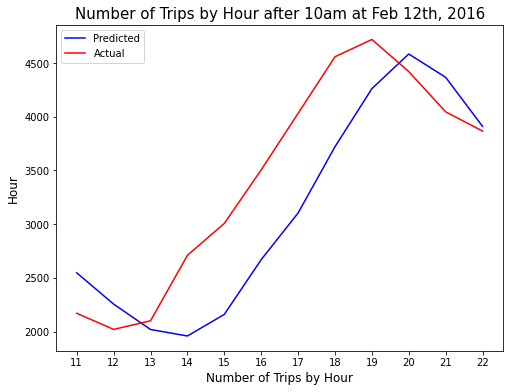

In [312]:
y_test = until22pm.iloc[train_value+1:,1].values


plt.figure(figsize=(8,6))
plt.plot(predict_trips, color='blue', label='Predicted')
plt.plot(y_test, color ='red', label='Actual')
plt.title('Number of Trips by Hour after 10am at Feb 12th, 2016',fontsize=15)
plt.xlabel('Number of Trips by Hour',fontsize=12)
plt.ylabel('Hour',fontsize=12)
plt.xticks(np.arange(12), np.arange(11,23))
plt.legend()
plt.show()

In [314]:
y_test = y_test.reshape(-1,1)
print('Mean Absolute Error: ', mean_absolute_error(y_test, predict_trips))
print('Mean Squared Error: ', mean_squared_error(y_test, predict_trips))

Mean Absolute Error:  490.0443350079504
Mean Squared Error:  340901.72852254525
